In [25]:
# Microsoft Turkey Summer Internship Program Project by Defne Meric Erdogan

In [26]:
# Importing libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import optuna
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import time
import os
from tqdm import trange
from sklearn.metrics import mean_squared_error, r2_score


In [27]:
os.makedirs("images", exist_ok=True)

In [28]:
# Importing the dataset
stocks = pd.read_csv('MSFT.csv')

# Data Analysis

In [29]:
print(stocks.head())

         Date      Open      High       Low     Close  Adj Close      Volume
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.061434  1031788800
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.063628   308160000
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.064725   133171200
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.063079    67766400
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.061982    47894400


In [30]:
print(stocks.describe())

              Open         High          Low        Close    Adj Close  \
count  9083.000000  9083.000000  9083.000000  9083.000000  9083.000000   
mean     41.324936    41.760887    40.878488    41.335628    36.256120   
std      59.696905    60.272218    59.081728    59.714567    59.981436   
min       0.088542     0.092014     0.088542     0.090278     0.057046   
25%       4.050781     4.102051     4.027344     4.075195     2.575089   
50%      26.820000    27.100000    26.520000    26.840000    18.948530   
75%      40.034999    40.443751    39.500000    39.937500    29.244812   
max     344.619995   349.670013   342.200012   343.109985   342.402008   

             Volume  
count  9.083000e+03  
mean   5.875055e+07  
std    3.845200e+07  
min    2.304000e+06  
25%    3.461230e+07  
50%    5.203200e+07  
75%    7.265400e+07  
max    1.031789e+09  


In [31]:
print(stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9083 non-null   object 
 1   Open       9083 non-null   float64
 2   High       9083 non-null   float64
 3   Low        9083 non-null   float64
 4   Close      9083 non-null   float64
 5   Adj Close  9083 non-null   float64
 6   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.9+ KB
None


In [32]:
print(stocks.isnull().sum()) # to check if there are any missing values we need to handle
# There are no missing values in the dataset

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Visualizing

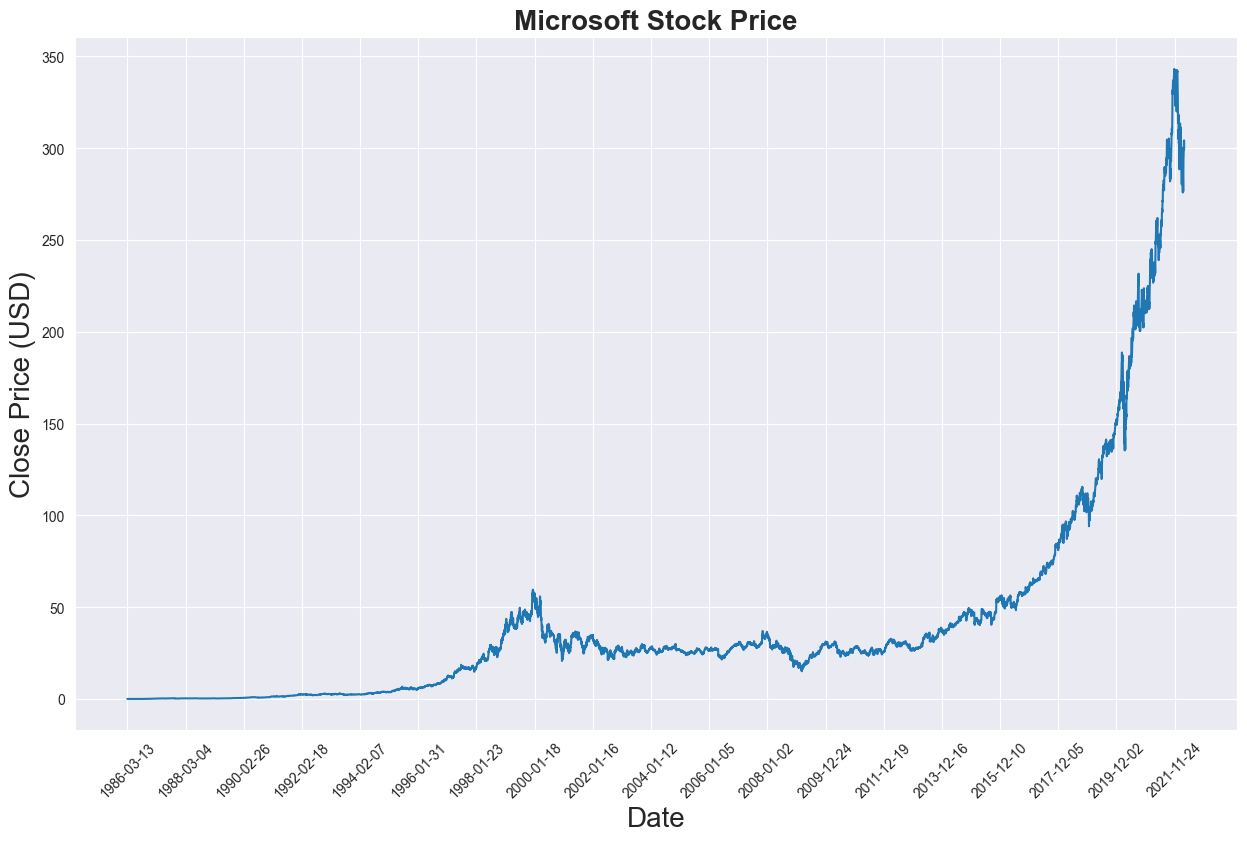

In [33]:
# We see the Close Price of the stock change with the time 
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(stocks['Close'])
plt.xticks(range(0,stocks.shape[0],500),stocks['Date'].loc[::500],rotation=45)
plt.title("Microsoft Stock Price",fontsize=20, fontweight='bold')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Close Price (USD)',fontsize=20)
plt.savefig('images/microsoft_stock_price.png')
plt.show()

## Handling Outliers

In [34]:
# Removes values that fall outside 1.5×IQR range:

Q1 = stocks['Close'].quantile(0.25)
Q3 = stocks['Close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stocks = stocks[(stocks['Close'] >= lower_bound) & (stocks['Close'] <= upper_bound)]


In [35]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8101
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8076 non-null   object 
 1   Open       8076 non-null   float64
 2   High       8076 non-null   float64
 3   Low        8076 non-null   float64
 4   Close      8076 non-null   float64
 5   Adj Close  8076 non-null   float64
 6   Volume     8076 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 504.8+ KB


## Normalizing Data

In [36]:
price = stocks[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8101
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8076 non-null   float64
dtypes: float64(1)
memory usage: 126.2 KB


In [37]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price = price.copy()
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [34]:
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


# Preparation for Model

In [38]:
# Using sliding window method 
# This creates training sampels by taking a sequence of past values and using them to predict the next values.
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0])) # 20% for testing
    train_set_size = data.shape[0] - (test_set_size) # 80% for training
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [39]:
# Transforming the data into tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Adding random seed for reproducibility
# 42 as its the Answer to the Ultimate Question of Life :D
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor).to(device)

Using device: cpu


# LSTM MODEL

In [40]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :]) 
        return out

## Finding Best Parameters with HyperParameter Optimization

In [41]:
# This class will stop the training if the validation loss does not improve for a certain number of epochs (patience)
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.early_stop 


In [42]:
def train_model_optuna(model, optimizer, criterion, train_loader, val_loader, epochs=100, patience=10):
    early_stopping = EarlyStopping(patience=patience)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break
    return val_loss


def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Model
    model = LSTM(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Data loaders
    dataset = TensorDataset(x_train, y_train_lstm)
    val_dataset = TensorDataset(x_test, y_test_lstm)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    val_loss = train_model_optuna(model, optimizer, criterion, train_loader, val_loader, epochs=100, patience=5)
    return val_loss


In [43]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=True, n_jobs=1)

print("Best trial:")
trial = study.best_trial
for key, value in trial.params.items():
    print(f"{key}: {value}")


[I 2025-07-27 14:27:55,669] A new study created in memory with name: no-name-07171a4c-49f4-414e-b7c7-2b68564f5eac
Best trial: 0. Best value: 0.00340203:   0%|          | 1/200 [01:10<3:53:39, 70.45s/it]

Early stopping at epoch 14
[I 2025-07-27 14:29:06,119] Trial 0 finished with value: 0.0034020324610002503 and parameters: {'hidden_dim': 217, 'num_layers': 2, 'lr': 0.00010840166190101046, 'batch_size': 32}. Best is trial 0 with value: 0.0034020324610002503.


Best trial: 1. Best value: 0.00308451:   1%|          | 2/200 [01:24<2:03:17, 37.36s/it]

Early stopping at epoch 25
[I 2025-07-27 14:29:20,316] Trial 1 finished with value: 0.0030845075200956603 and parameters: {'hidden_dim': 39, 'num_layers': 1, 'lr': 0.0037682887733131126, 'batch_size': 64}. Best is trial 1 with value: 0.0030845075200956603.


Best trial: 2. Best value: 0.000696959:   2%|▏         | 3/200 [01:55<1:53:06, 34.45s/it]

Early stopping at epoch 20
[I 2025-07-27 14:29:51,308] Trial 2 finished with value: 0.0006969588533798279 and parameters: {'hidden_dim': 59, 'num_layers': 2, 'lr': 0.008305992362161117, 'batch_size': 32}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   2%|▏         | 4/200 [02:12<1:29:21, 27.35s/it]

Early stopping at epoch 12
[I 2025-07-27 14:30:07,783] Trial 3 finished with value: 0.0012083200081878414 and parameters: {'hidden_dim': 193, 'num_layers': 1, 'lr': 0.0018989193063918808, 'batch_size': 128}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   2%|▎         | 5/200 [05:15<4:31:59, 83.69s/it]

Early stopping at epoch 25
[I 2025-07-27 14:33:11,354] Trial 4 finished with value: 0.003115199764299457 and parameters: {'hidden_dim': 140, 'num_layers': 3, 'lr': 0.0004394524841019309, 'batch_size': 64}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   3%|▎         | 6/200 [05:41<3:27:04, 64.04s/it]

Early stopping at epoch 18
[I 2025-07-27 14:33:37,260] Trial 5 finished with value: 0.0019234570757432196 and parameters: {'hidden_dim': 66, 'num_layers': 2, 'lr': 0.000770830434514262, 'batch_size': 64}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   4%|▎         | 7/200 [10:13<7:04:05, 131.84s/it]

Early stopping at epoch 38
[I 2025-07-27 14:38:08,695] Trial 6 finished with value: 0.0050539282250718 and parameters: {'hidden_dim': 69, 'num_layers': 3, 'lr': 0.00012604829547198517, 'batch_size': 32}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   4%|▍         | 8/200 [11:14<5:50:14, 109.45s/it]

Early stopping at epoch 8
[I 2025-07-27 14:39:10,198] Trial 7 finished with value: 0.001662667793068834 and parameters: {'hidden_dim': 81, 'num_layers': 2, 'lr': 0.001999293164116531, 'batch_size': 32}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   4%|▍         | 9/200 [12:56<5:41:03, 107.14s/it]

[I 2025-07-27 14:40:52,255] Trial 8 finished with value: 0.01887846226992014 and parameters: {'hidden_dim': 37, 'num_layers': 3, 'lr': 0.00019480318411688391, 'batch_size': 128}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   5%|▌         | 10/200 [17:38<8:29:52, 161.01s/it]

Early stopping at epoch 16
[I 2025-07-27 14:45:33,899] Trial 9 finished with value: 0.001563972236628895 and parameters: {'hidden_dim': 118, 'num_layers': 3, 'lr': 0.004412062410792844, 'batch_size': 64}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   6%|▌         | 11/200 [18:56<7:07:49, 135.82s/it]

Early stopping at epoch 27
[I 2025-07-27 14:46:52,590] Trial 10 finished with value: 0.0013272049941673793 and parameters: {'hidden_dim': 250, 'num_layers': 1, 'lr': 0.008753479239125334, 'batch_size': 32}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   6%|▌         | 12/200 [19:28<5:25:56, 104.02s/it]

Early stopping at epoch 24
[I 2025-07-27 14:47:23,889] Trial 11 finished with value: 0.0010621617525780143 and parameters: {'hidden_dim': 186, 'num_layers': 1, 'lr': 0.009655477181724657, 'batch_size': 128}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   6%|▋         | 13/200 [19:52<4:08:27, 79.72s/it] 

Early stopping at epoch 19
[I 2025-07-27 14:47:47,692] Trial 12 finished with value: 0.001621802439331077 and parameters: {'hidden_dim': 172, 'num_layers': 1, 'lr': 0.009976038280467647, 'batch_size': 128}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   7%|▋         | 14/200 [20:33<3:30:52, 68.03s/it]

Early stopping at epoch 19
[I 2025-07-27 14:48:28,695] Trial 13 finished with value: 0.0034399442441868954 and parameters: {'hidden_dim': 114, 'num_layers': 2, 'lr': 0.005027237223261295, 'batch_size': 128}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 2. Best value: 0.000696959:   8%|▊         | 15/200 [20:41<2:34:25, 50.08s/it]

Early stopping at epoch 6
[I 2025-07-27 14:48:37,198] Trial 14 finished with value: 0.003197347434112229 and parameters: {'hidden_dim': 165, 'num_layers': 1, 'lr': 0.0020931808134186693, 'batch_size': 128}. Best is trial 2 with value: 0.0006969588533798279.


Best trial: 15. Best value: 0.000495939:   8%|▊         | 16/200 [21:44<2:45:21, 53.92s/it]

Early stopping at epoch 11
[I 2025-07-27 14:49:40,032] Trial 15 finished with value: 0.0004959388395803341 and parameters: {'hidden_dim': 219, 'num_layers': 2, 'lr': 0.007400351285963949, 'batch_size': 32}. Best is trial 15 with value: 0.0004959388395803341.


Best trial: 16. Best value: 0.000474701:   8%|▊         | 17/200 [23:48<3:48:32, 74.93s/it]

Early stopping at epoch 19
[I 2025-07-27 14:51:43,819] Trial 16 finished with value: 0.00047470101651247114 and parameters: {'hidden_dim': 251, 'num_layers': 2, 'lr': 0.00097657985785494, 'batch_size': 32}. Best is trial 16 with value: 0.00047470101651247114.


Best trial: 17. Best value: 0.00045567:   9%|▉         | 18/200 [26:26<5:03:44, 100.14s/it]

Early stopping at epoch 27
[I 2025-07-27 14:54:22,635] Trial 17 finished with value: 0.00045567002455879676 and parameters: {'hidden_dim': 242, 'num_layers': 2, 'lr': 0.0007496673405810093, 'batch_size': 32}. Best is trial 17 with value: 0.00045567002455879676.


Best trial: 17. Best value: 0.00045567:  10%|▉         | 19/200 [27:15<4:14:57, 84.52s/it] 

Early stopping at epoch 8
[I 2025-07-27 14:55:10,761] Trial 18 finished with value: 0.0008128553863036144 and parameters: {'hidden_dim': 249, 'num_layers': 2, 'lr': 0.0005000822943850137, 'batch_size': 32}. Best is trial 17 with value: 0.00045567002455879676.


Best trial: 17. Best value: 0.00045567:  10%|█         | 20/200 [27:55<3:33:35, 71.19s/it]

Early stopping at epoch 7
[I 2025-07-27 14:55:50,909] Trial 19 finished with value: 0.0024077107577171524 and parameters: {'hidden_dim': 225, 'num_layers': 2, 'lr': 0.001065080855173458, 'batch_size': 32}. Best is trial 17 with value: 0.00045567002455879676.


Best trial: 17. Best value: 0.00045567:  10%|█         | 21/200 [29:41<4:03:23, 81.58s/it]

Early stopping at epoch 11
[I 2025-07-27 14:57:36,712] Trial 20 finished with value: 0.0020593238722558097 and parameters: {'hidden_dim': 253, 'num_layers': 3, 'lr': 0.0003127425859907237, 'batch_size': 32}. Best is trial 17 with value: 0.00045567002455879676.


Best trial: 17. Best value: 0.00045567:  11%|█         | 22/200 [30:14<3:18:50, 67.03s/it]

Early stopping at epoch 5
[I 2025-07-27 14:58:09,787] Trial 21 finished with value: 0.001533153803999691 and parameters: {'hidden_dim': 220, 'num_layers': 2, 'lr': 0.0010935936982880957, 'batch_size': 32}. Best is trial 17 with value: 0.00045567002455879676.


Best trial: 22. Best value: 0.000352887:  12%|█▏        | 23/200 [31:59<3:51:45, 78.56s/it]

Early stopping at epoch 19
[I 2025-07-27 14:59:55,259] Trial 22 finished with value: 0.000352886841545685 and parameters: {'hidden_dim': 232, 'num_layers': 2, 'lr': 0.0006914645478577998, 'batch_size': 32}. Best is trial 22 with value: 0.000352886841545685.


Best trial: 22. Best value: 0.000352887:  12%|█▏        | 24/200 [33:01<3:36:11, 73.70s/it]

Early stopping at epoch 9
[I 2025-07-27 15:00:57,616] Trial 23 finished with value: 0.0009360816425303746 and parameters: {'hidden_dim': 235, 'num_layers': 2, 'lr': 0.0006853423951109587, 'batch_size': 32}. Best is trial 22 with value: 0.000352886841545685.


Best trial: 22. Best value: 0.000352887:  12%|█▎        | 25/200 [33:50<3:12:55, 66.14s/it]

Early stopping at epoch 9
[I 2025-07-27 15:01:46,134] Trial 24 finished with value: 0.0008871062036989458 and parameters: {'hidden_dim': 200, 'num_layers': 2, 'lr': 0.00130068289742117, 'batch_size': 32}. Best is trial 22 with value: 0.000352886841545685.


Best trial: 22. Best value: 0.000352887:  13%|█▎        | 26/200 [36:59<4:59:05, 103.14s/it]

Early stopping at epoch 32
[I 2025-07-27 15:04:55,575] Trial 25 finished with value: 0.0005213875896622674 and parameters: {'hidden_dim': 236, 'num_layers': 2, 'lr': 0.00041567231415209395, 'batch_size': 32}. Best is trial 22 with value: 0.000352886841545685.


Best trial: 22. Best value: 0.000352887:  14%|█▎        | 27/200 [38:12<4:30:54, 93.96s/it] 

Early stopping at epoch 9
[I 2025-07-27 15:06:08,113] Trial 26 finished with value: 0.0034756717054109437 and parameters: {'hidden_dim': 210, 'num_layers': 3, 'lr': 0.0006762601804318701, 'batch_size': 32}. Best is trial 22 with value: 0.000352886841545685.


Best trial: 22. Best value: 0.000352887:  14%|█▍        | 28/200 [38:50<3:41:13, 77.17s/it]

Early stopping at epoch 6
[I 2025-07-27 15:06:46,125] Trial 27 finished with value: 0.0013825091767762834 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'lr': 0.0002814115992428759, 'batch_size': 32}. Best is trial 22 with value: 0.000352886841545685.


Best trial: 22. Best value: 0.000352887:  14%|█▍        | 29/200 [42:22<5:35:30, 117.72s/it]

Early stopping at epoch 20
[I 2025-07-27 15:10:18,455] Trial 28 finished with value: 0.0006282410767573096 and parameters: {'hidden_dim': 236, 'num_layers': 2, 'lr': 0.0014733918380584932, 'batch_size': 32}. Best is trial 22 with value: 0.000352886841545685.


Best trial: 29. Best value: 0.0003053:  15%|█▌        | 30/200 [43:33<4:53:46, 103.69s/it]  

Early stopping at epoch 31
[I 2025-07-27 15:11:29,397] Trial 29 finished with value: 0.0003052997519048136 and parameters: {'hidden_dim': 206, 'num_layers': 1, 'lr': 0.0028159705451446058, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  16%|█▌        | 31/200 [49:58<8:49:47, 188.09s/it]

Early stopping at epoch 57
[I 2025-07-27 15:17:54,427] Trial 30 finished with value: 0.0014504792683370537 and parameters: {'hidden_dim': 175, 'num_layers': 1, 'lr': 0.003387509982953915, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  16%|█▌        | 32/200 [50:15<6:23:05, 136.82s/it]

Early stopping at epoch 7
[I 2025-07-27 15:18:11,618] Trial 31 finished with value: 0.0015178465875186364 and parameters: {'hidden_dim': 203, 'num_layers': 1, 'lr': 0.0008200124813890369, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  16%|█▋        | 33/200 [51:28<5:27:10, 117.55s/it]

Early stopping at epoch 28
[I 2025-07-27 15:19:24,202] Trial 32 finished with value: 0.0007192764527394948 and parameters: {'hidden_dim': 232, 'num_layers': 1, 'lr': 0.0028652083036089324, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  17%|█▋        | 34/200 [56:42<8:08:15, 176.48s/it]

Early stopping at epoch 9
[I 2025-07-27 15:24:38,181] Trial 33 finished with value: 0.0016669736283160199 and parameters: {'hidden_dim': 211, 'num_layers': 2, 'lr': 0.0005282818251480979, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  18%|█▊        | 35/200 [57:22<6:12:49, 135.57s/it]

Early stopping at epoch 19
[I 2025-07-27 15:25:18,307] Trial 34 finished with value: 0.001004063126553471 and parameters: {'hidden_dim': 186, 'num_layers': 1, 'lr': 0.0014779846127074155, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  18%|█▊        | 36/200 [1:00:15<6:40:49, 146.64s/it]

Early stopping at epoch 21
[I 2025-07-27 15:28:10,778] Trial 35 finished with value: 0.0004114559079051319 and parameters: {'hidden_dim': 242, 'num_layers': 3, 'lr': 0.000917335877036694, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  18%|█▊        | 37/200 [1:24:00<24:00:37, 530.29s/it]

Early stopping at epoch 20
[I 2025-07-27 15:51:56,245] Trial 36 finished with value: 0.002636570902933062 and parameters: {'hidden_dim': 226, 'num_layers': 3, 'lr': 0.0025427861688419712, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  19%|█▉        | 38/200 [1:26:57<19:05:26, 424.24s/it]

Early stopping at epoch 11
[I 2025-07-27 15:54:53,032] Trial 37 finished with value: 0.0022369452910389357 and parameters: {'hidden_dim': 139, 'num_layers': 3, 'lr': 0.00029591830328414324, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  20%|█▉        | 39/200 [1:28:26<14:28:18, 323.60s/it]

Early stopping at epoch 7
[I 2025-07-27 15:56:21,792] Trial 38 finished with value: 0.003978723079889474 and parameters: {'hidden_dim': 240, 'num_layers': 3, 'lr': 0.0006074199403154418, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  20%|██        | 40/200 [1:29:57<11:17:19, 253.99s/it]

Early stopping at epoch 18
[I 2025-07-27 15:57:53,383] Trial 39 finished with value: 0.0056394199477486275 and parameters: {'hidden_dim': 160, 'num_layers': 3, 'lr': 0.000926634055068839, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  20%|██        | 41/200 [1:30:22<8:10:54, 185.25s/it] 

Early stopping at epoch 10
[I 2025-07-27 15:58:18,227] Trial 40 finished with value: 0.0015961631344158806 and parameters: {'hidden_dim': 196, 'num_layers': 1, 'lr': 0.00037865933618290594, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  21%|██        | 42/200 [1:32:06<7:03:49, 160.94s/it]

Early stopping at epoch 18
[I 2025-07-27 16:00:02,462] Trial 41 finished with value: 0.000376734314212466 and parameters: {'hidden_dim': 245, 'num_layers': 2, 'lr': 0.0011977274607164726, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  22%|██▏       | 43/200 [1:33:25<5:56:53, 136.39s/it]

Early stopping at epoch 13
[I 2025-07-27 16:01:21,565] Trial 42 finished with value: 0.0008951189797074881 and parameters: {'hidden_dim': 243, 'num_layers': 2, 'lr': 0.0017589954919771168, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  22%|██▏       | 44/200 [1:34:27<4:56:24, 114.00s/it]

Early stopping at epoch 12
[I 2025-07-27 16:02:23,322] Trial 43 finished with value: 0.0006178807328551021 and parameters: {'hidden_dim': 212, 'num_layers': 2, 'lr': 0.0012647912045102277, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  22%|██▎       | 45/200 [1:36:11<4:46:32, 110.92s/it]

Early stopping at epoch 19
[I 2025-07-27 16:04:07,043] Trial 44 finished with value: 0.0017315859319448161 and parameters: {'hidden_dim': 227, 'num_layers': 2, 'lr': 0.005764463602644603, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  23%|██▎       | 46/200 [1:36:49<3:48:56, 89.20s/it] 

Early stopping at epoch 6
[I 2025-07-27 16:04:45,552] Trial 45 finished with value: 0.0012764307891712616 and parameters: {'hidden_dim': 244, 'num_layers': 2, 'lr': 0.0008171320809737258, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  24%|██▎       | 47/200 [1:37:17<3:00:27, 70.77s/it]

Early stopping at epoch 16
[I 2025-07-27 16:05:13,334] Trial 46 finished with value: 0.007017800103102882 and parameters: {'hidden_dim': 94, 'num_layers': 2, 'lr': 0.0005643183240246691, 'batch_size': 128}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  24%|██▍       | 48/200 [1:40:19<4:23:32, 104.03s/it]

Early stopping at epoch 26
[I 2025-07-27 16:08:14,971] Trial 47 finished with value: 0.001384406213429219 and parameters: {'hidden_dim': 217, 'num_layers': 3, 'lr': 0.00015207763368523862, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  24%|██▍       | 49/200 [1:41:46<4:08:51, 98.88s/it] 

Early stopping at epoch 19
[I 2025-07-27 16:09:41,841] Trial 48 finished with value: 0.0005212646402451712 and parameters: {'hidden_dim': 188, 'num_layers': 2, 'lr': 0.0023300667592289566, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  25%|██▌       | 50/200 [1:42:48<3:39:58, 87.99s/it]

Early stopping at epoch 22
[I 2025-07-27 16:10:44,425] Trial 49 finished with value: 0.00034638689783819513 and parameters: {'hidden_dim': 243, 'num_layers': 1, 'lr': 0.001671586417989286, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  26%|██▌       | 51/200 [1:42:59<2:41:04, 64.86s/it]

Early stopping at epoch 7
[I 2025-07-27 16:10:55,306] Trial 50 finished with value: 0.0008178064622020778 and parameters: {'hidden_dim': 206, 'num_layers': 1, 'lr': 0.001800946812727662, 'batch_size': 128}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  26%|██▌       | 52/200 [1:43:15<2:03:30, 50.07s/it]

Early stopping at epoch 5
[I 2025-07-27 16:11:10,866] Trial 51 finished with value: 0.0008557402555500934 and parameters: {'hidden_dim': 243, 'num_layers': 1, 'lr': 0.0030727441522396723, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  26%|██▋       | 53/200 [1:43:38<1:43:01, 42.05s/it]

Early stopping at epoch 9
[I 2025-07-27 16:11:34,207] Trial 52 finished with value: 0.0010641886980082228 and parameters: {'hidden_dim': 230, 'num_layers': 1, 'lr': 0.0011863067778059555, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  27%|██▋       | 54/200 [1:44:26<1:46:38, 43.83s/it]

Early stopping at epoch 20
[I 2025-07-27 16:12:22,177] Trial 53 finished with value: 0.0010224266598194006 and parameters: {'hidden_dim': 220, 'num_layers': 1, 'lr': 0.003898047093336279, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  28%|██▊       | 55/200 [1:44:58<1:37:21, 40.28s/it]

Early stopping at epoch 5
[I 2025-07-27 16:12:54,193] Trial 54 finished with value: 0.0017229860155459713 and parameters: {'hidden_dim': 248, 'num_layers': 2, 'lr': 0.0015668244193941488, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  28%|██▊       | 56/200 [1:45:21<1:24:16, 35.12s/it]

Early stopping at epoch 7
[I 2025-07-27 16:13:17,256] Trial 55 finished with value: 0.0017964042476081637 and parameters: {'hidden_dim': 253, 'num_layers': 1, 'lr': 0.0008860972684419567, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  28%|██▊       | 57/200 [1:47:21<2:24:07, 60.47s/it]

Early stopping at epoch 22
[I 2025-07-27 16:15:16,894] Trial 56 finished with value: 0.00045111609820285627 and parameters: {'hidden_dim': 238, 'num_layers': 2, 'lr': 0.0007053607300297704, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  29%|██▉       | 58/200 [1:49:50<3:26:08, 87.10s/it]

Early stopping at epoch 24
[I 2025-07-27 16:17:46,133] Trial 57 finished with value: 0.00031794154175954377 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'lr': 0.0021030841845601986, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  30%|██▉       | 59/200 [1:50:16<2:41:54, 68.89s/it]

Early stopping at epoch 16
[I 2025-07-27 16:18:12,542] Trial 58 finished with value: 0.002116328922476476 and parameters: {'hidden_dim': 225, 'num_layers': 1, 'lr': 0.002120947872963786, 'batch_size': 128}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  30%|███       | 60/200 [1:52:28<3:24:38, 87.71s/it]

Early stopping at epoch 14
[I 2025-07-27 16:20:24,142] Trial 59 finished with value: 0.008895192992663486 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'lr': 0.004404813461332136, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  30%|███       | 61/200 [1:53:50<3:19:29, 86.11s/it]

Early stopping at epoch 15
[I 2025-07-27 16:21:46,532] Trial 60 finished with value: 0.00044231852228346954 and parameters: {'hidden_dim': 232, 'num_layers': 2, 'lr': 0.0026890527047495247, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  31%|███       | 62/200 [1:55:42<3:35:59, 93.91s/it]

Early stopping at epoch 22
[I 2025-07-27 16:23:38,647] Trial 61 finished with value: 0.00047866593961896117 and parameters: {'hidden_dim': 232, 'num_layers': 2, 'lr': 0.002564896473689019, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  32%|███▏      | 63/200 [1:57:32<3:45:00, 98.54s/it]

Early stopping at epoch 20
[I 2025-07-27 16:25:27,992] Trial 62 finished with value: 0.0005296800165310475 and parameters: {'hidden_dim': 246, 'num_layers': 2, 'lr': 0.001829053627495655, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  32%|███▏      | 64/200 [1:58:33<3:18:02, 87.37s/it]

Early stopping at epoch 12
[I 2025-07-27 16:26:29,300] Trial 63 finished with value: 0.0007164883926652335 and parameters: {'hidden_dim': 217, 'num_layers': 2, 'lr': 0.0010586804827627913, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  32%|███▎      | 65/200 [2:00:15<3:26:05, 91.59s/it]

Early stopping at epoch 18
[I 2025-07-27 16:28:10,746] Trial 64 finished with value: 0.0010852707876919715 and parameters: {'hidden_dim': 249, 'num_layers': 2, 'lr': 0.0035697289821684684, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  33%|███▎      | 66/200 [2:02:26<3:50:55, 103.40s/it]

Early stopping at epoch 26
[I 2025-07-27 16:30:21,689] Trial 65 finished with value: 0.0004153260299918817 and parameters: {'hidden_dim': 225, 'num_layers': 2, 'lr': 0.0014226353952826625, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  34%|███▎      | 67/200 [2:04:03<3:45:14, 101.61s/it]

Early stopping at epoch 19
[I 2025-07-27 16:31:59,141] Trial 66 finished with value: 0.0003238892781618964 and parameters: {'hidden_dim': 222, 'num_layers': 2, 'lr': 0.0013975611922482252, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  34%|███▍      | 68/200 [2:04:19<2:46:58, 75.90s/it] 

Early stopping at epoch 13
[I 2025-07-27 16:32:15,043] Trial 67 finished with value: 0.006856256228414937 and parameters: {'hidden_dim': 48, 'num_layers': 2, 'lr': 0.0022262139439968463, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  34%|███▍      | 69/200 [2:05:02<2:24:16, 66.08s/it]

Early stopping at epoch 13
[I 2025-07-27 16:32:58,215] Trial 68 finished with value: 0.0006011826601524281 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'lr': 0.0016447877204975292, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  35%|███▌      | 70/200 [2:06:40<2:44:05, 75.73s/it]

Early stopping at epoch 27
[I 2025-07-27 16:34:36,459] Trial 69 finished with value: 0.0006809466120138691 and parameters: {'hidden_dim': 129, 'num_layers': 2, 'lr': 0.001188176796716996, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  36%|███▌      | 71/200 [2:07:13<2:14:54, 62.74s/it]

Early stopping at epoch 12
[I 2025-07-27 16:35:08,902] Trial 70 finished with value: 0.001444229814617703 and parameters: {'hidden_dim': 237, 'num_layers': 1, 'lr': 0.0010021986119269084, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  36%|███▌      | 72/200 [2:11:19<4:11:01, 117.67s/it]

Early stopping at epoch 18
[I 2025-07-27 16:39:14,736] Trial 71 finished with value: 0.00032731471233715887 and parameters: {'hidden_dim': 222, 'num_layers': 2, 'lr': 0.001477736258279832, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  36%|███▋      | 73/200 [2:12:33<3:41:30, 104.65s/it]

Early stopping at epoch 13
[I 2025-07-27 16:40:28,999] Trial 72 finished with value: 0.0005946551024738024 and parameters: {'hidden_dim': 209, 'num_layers': 2, 'lr': 0.0013820086975703545, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  37%|███▋      | 74/200 [2:14:01<3:29:23, 99.71s/it] 

Early stopping at epoch 12
[I 2025-07-27 16:41:57,174] Trial 73 finished with value: 0.000568771011446598 and parameters: {'hidden_dim': 219, 'num_layers': 2, 'lr': 0.0019405408609908094, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  38%|███▊      | 75/200 [2:15:25<3:17:50, 94.96s/it]

Early stopping at epoch 19
[I 2025-07-27 16:43:21,060] Trial 74 finished with value: 0.0006188429671216427 and parameters: {'hidden_dim': 197, 'num_layers': 2, 'lr': 0.0011630007823030851, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  38%|███▊      | 76/200 [2:22:17<6:33:10, 190.24s/it]

Early stopping at epoch 6
[I 2025-07-27 16:50:13,634] Trial 75 finished with value: 0.0018448317339646689 and parameters: {'hidden_dim': 241, 'num_layers': 2, 'lr': 0.0015921897638624088, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  38%|███▊      | 77/200 [2:31:11<10:01:00, 293.17s/it]

Early stopping at epoch 13
[I 2025-07-27 16:59:06,967] Trial 76 finished with value: 0.002890407608313527 and parameters: {'hidden_dim': 214, 'num_layers': 3, 'lr': 0.0008777926683109141, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  39%|███▉      | 78/200 [2:32:08<7:31:53, 222.24s/it] 

Early stopping at epoch 21
[I 2025-07-27 17:00:03,696] Trial 77 finished with value: 0.0024112141500854003 and parameters: {'hidden_dim': 204, 'num_layers': 2, 'lr': 0.003153177661984204, 'batch_size': 128}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  40%|███▉      | 79/200 [2:42:32<11:31:41, 342.99s/it]

Early stopping at epoch 9
[I 2025-07-27 17:10:28,436] Trial 78 finished with value: 0.0015986438211614002 and parameters: {'hidden_dim': 248, 'num_layers': 2, 'lr': 0.0006456545451017209, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  40%|████      | 80/200 [2:45:37<9:50:44, 295.37s/it] 

Early stopping at epoch 46
[I 2025-07-27 17:13:32,707] Trial 79 finished with value: 0.0003784970772707871 and parameters: {'hidden_dim': 179, 'num_layers': 2, 'lr': 0.0012940604716625845, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  40%|████      | 81/200 [2:46:19<7:15:23, 219.52s/it]

Early stopping at epoch 10
[I 2025-07-27 17:14:15,242] Trial 80 finished with value: 0.0027803914764752756 and parameters: {'hidden_dim': 179, 'num_layers': 2, 'lr': 0.0013239377347488508, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  41%|████      | 82/200 [2:47:27<5:42:23, 174.09s/it]

Early stopping at epoch 19
[I 2025-07-27 17:15:23,340] Trial 81 finished with value: 0.0006781207761937716 and parameters: {'hidden_dim': 162, 'num_layers': 2, 'lr': 0.0020202131329836778, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  42%|████▏     | 83/200 [2:48:36<4:37:41, 142.41s/it]

Early stopping at epoch 16
[I 2025-07-27 17:16:31,818] Trial 82 finished with value: 0.0016651398484380199 and parameters: {'hidden_dim': 191, 'num_layers': 2, 'lr': 0.000987747711888031, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  42%|████▏     | 84/200 [2:49:52<3:56:54, 122.54s/it]

Early stopping at epoch 15
[I 2025-07-27 17:17:47,997] Trial 83 finished with value: 0.002264048231993981 and parameters: {'hidden_dim': 221, 'num_layers': 2, 'lr': 0.0007990867170220694, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  42%|████▎     | 85/200 [2:51:04<3:25:50, 107.39s/it]

Early stopping at epoch 15
[I 2025-07-27 17:19:00,044] Trial 84 finished with value: 0.0012296420922771527 and parameters: {'hidden_dim': 229, 'num_layers': 2, 'lr': 0.0016804974440990143, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  43%|████▎     | 86/200 [2:51:30<2:37:41, 83.00s/it] 

Early stopping at epoch 12
[I 2025-07-27 17:19:26,113] Trial 85 finished with value: 0.0005017454853206052 and parameters: {'hidden_dim': 151, 'num_layers': 1, 'lr': 0.002433470183410258, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  44%|████▎     | 87/200 [2:54:04<3:16:29, 104.33s/it]

Early stopping at epoch 19
[I 2025-07-27 17:22:00,230] Trial 86 finished with value: 0.00036885140035141663 and parameters: {'hidden_dim': 234, 'num_layers': 3, 'lr': 0.0011059171354048812, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  44%|████▍     | 88/200 [2:54:45<2:39:27, 85.43s/it] 

Early stopping at epoch 8
[I 2025-07-27 17:22:41,544] Trial 87 finished with value: 0.0019256270461482927 and parameters: {'hidden_dim': 179, 'num_layers': 2, 'lr': 0.0013012267949111872, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  44%|████▍     | 89/200 [2:55:31<2:16:09, 73.60s/it]

Early stopping at epoch 8
[I 2025-07-27 17:23:27,544] Trial 88 finished with value: 0.001822522422812386 and parameters: {'hidden_dim': 234, 'num_layers': 2, 'lr': 0.001151643184001595, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  45%|████▌     | 90/200 [2:55:51<1:45:06, 57.33s/it]

Early stopping at epoch 7
[I 2025-07-27 17:23:46,930] Trial 89 finished with value: 0.0010728336284028402 and parameters: {'hidden_dim': 199, 'num_layers': 1, 'lr': 0.0019760391204827845, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  46%|████▌     | 91/200 [2:56:17<1:26:59, 47.88s/it]

Early stopping at epoch 5
[I 2025-07-27 17:24:12,762] Trial 90 finished with value: 0.0008700458420207724 and parameters: {'hidden_dim': 224, 'num_layers': 2, 'lr': 0.0014600507792098976, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  46%|████▌     | 92/200 [2:58:25<2:09:30, 71.94s/it]

Early stopping at epoch 16
[I 2025-07-27 17:26:20,847] Trial 91 finished with value: 0.0005947824542019196 and parameters: {'hidden_dim': 240, 'num_layers': 3, 'lr': 0.0009174994380098386, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  46%|████▋     | 93/200 [3:01:47<3:17:54, 110.97s/it]

Early stopping at epoch 23
[I 2025-07-27 17:29:42,891] Trial 92 finished with value: 0.0003642212140417256 and parameters: {'hidden_dim': 252, 'num_layers': 3, 'lr': 0.0004520395498916484, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  47%|████▋     | 94/200 [3:03:20<3:06:30, 105.57s/it]

Early stopping at epoch 9
[I 2025-07-27 17:31:15,855] Trial 93 finished with value: 0.003494037060162929 and parameters: {'hidden_dim': 250, 'num_layers': 3, 'lr': 0.00048020787718576144, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  48%|████▊     | 95/200 [3:07:19<4:14:53, 145.65s/it]

Early stopping at epoch 30
[I 2025-07-27 17:35:15,017] Trial 94 finished with value: 0.0007715902868178947 and parameters: {'hidden_dim': 236, 'num_layers': 3, 'lr': 0.0004677401313033898, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  48%|████▊     | 96/200 [3:08:48<3:43:04, 128.70s/it]

Early stopping at epoch 10
[I 2025-07-27 17:36:44,169] Trial 95 finished with value: 0.002222778683062643 and parameters: {'hidden_dim': 246, 'num_layers': 3, 'lr': 0.000371431752450318, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  48%|████▊     | 97/200 [3:09:54<3:08:48, 109.98s/it]

Early stopping at epoch 12
[I 2025-07-27 17:37:50,481] Trial 96 finished with value: 0.0030823263581483983 and parameters: {'hidden_dim': 230, 'num_layers': 3, 'lr': 0.0007597707702717681, 'batch_size': 128}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  49%|████▉     | 98/200 [3:10:40<2:34:06, 90.65s/it] 

Early stopping at epoch 8
[I 2025-07-27 17:38:36,013] Trial 97 finished with value: 0.001080368993308523 and parameters: {'hidden_dim': 207, 'num_layers': 2, 'lr': 0.0005682518236194722, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  50%|████▉     | 99/200 [3:12:25<2:40:05, 95.10s/it]

Early stopping at epoch 13
[I 2025-07-27 17:40:21,513] Trial 98 finished with value: 0.0018764508197765442 and parameters: {'hidden_dim': 214, 'num_layers': 3, 'lr': 0.002862119310704158, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  50%|█████     | 100/200 [3:13:38<2:27:13, 88.33s/it]

Early stopping at epoch 11
[I 2025-07-27 17:41:34,046] Trial 99 finished with value: 0.00292120263175628 and parameters: {'hidden_dim': 252, 'num_layers': 2, 'lr': 0.00021804837940061247, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  50%|█████     | 101/200 [3:14:16<2:00:51, 73.25s/it]

Early stopping at epoch 17
[I 2025-07-27 17:42:12,091] Trial 100 finished with value: 0.0004112128349244777 and parameters: {'hidden_dim': 170, 'num_layers': 1, 'lr': 0.002258266141574013, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  51%|█████     | 102/200 [3:14:49<1:39:53, 61.16s/it]

Early stopping at epoch 17
[I 2025-07-27 17:42:45,038] Trial 101 finished with value: 0.0007136011192736024 and parameters: {'hidden_dim': 154, 'num_layers': 1, 'lr': 0.002277328177204731, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  52%|█████▏    | 103/200 [3:15:36<1:31:51, 56.82s/it]

Early stopping at epoch 24
[I 2025-07-27 17:43:31,748] Trial 102 finished with value: 0.0010544243847891944 and parameters: {'hidden_dim': 172, 'num_layers': 1, 'lr': 0.000101295645209458, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  52%|█████▏    | 104/200 [3:15:50<1:10:45, 44.22s/it]

Early stopping at epoch 5
[I 2025-07-27 17:43:46,575] Trial 103 finished with value: 0.0014192038219263457 and parameters: {'hidden_dim': 244, 'num_layers': 1, 'lr': 0.0015179380556680651, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  52%|█████▎    | 105/200 [3:16:04<55:25, 35.00s/it]  

Early stopping at epoch 6
[I 2025-07-27 17:44:00,062] Trial 104 finished with value: 0.001181957503029159 and parameters: {'hidden_dim': 182, 'num_layers': 1, 'lr': 0.0017814817509725393, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  53%|█████▎    | 106/200 [3:16:18<45:04, 28.77s/it]

Early stopping at epoch 7
[I 2025-07-27 17:44:14,279] Trial 105 finished with value: 0.001213484820789959 and parameters: {'hidden_dim': 167, 'num_layers': 1, 'lr': 0.001069721370529326, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  54%|█████▎    | 107/200 [3:17:17<58:37, 37.82s/it]

Early stopping at epoch 12
[I 2025-07-27 17:45:13,222] Trial 106 finished with value: 0.0006222977132054831 and parameters: {'hidden_dim': 222, 'num_layers': 2, 'lr': 0.001245229227770798, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  54%|█████▍    | 108/200 [3:18:13<1:06:21, 43.28s/it]

Early stopping at epoch 22
[I 2025-07-27 17:46:09,245] Trial 107 finished with value: 0.0005322869307265672 and parameters: {'hidden_dim': 238, 'num_layers': 1, 'lr': 0.002139573402735889, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  55%|█████▍    | 109/200 [3:20:24<1:45:19, 69.44s/it]

Early stopping at epoch 26
[I 2025-07-27 17:48:19,729] Trial 108 finished with value: 0.0006231579354432909 and parameters: {'hidden_dim': 229, 'num_layers': 2, 'lr': 0.0016679014844424669, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  55%|█████▌    | 110/200 [3:23:08<2:27:06, 98.07s/it]

Early stopping at epoch 29
[I 2025-07-27 17:51:04,589] Trial 109 finished with value: 0.00044567746861538777 and parameters: {'hidden_dim': 253, 'num_layers': 2, 'lr': 0.0027153574008921943, 'batch_size': 32}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 29. Best value: 0.0003053:  56%|█████▌    | 111/200 [3:24:11<2:09:27, 87.28s/it]

Early stopping at epoch 10
[I 2025-07-27 17:52:06,687] Trial 110 finished with value: 0.0032075621006347668 and parameters: {'hidden_dim': 194, 'num_layers': 3, 'lr': 0.004205842400032108, 'batch_size': 64}. Best is trial 29 with value: 0.0003052997519048136.


Best trial: 111. Best value: 0.000278963:  56%|█████▌    | 112/200 [3:33:04<5:24:23, 221.18s/it]

Early stopping at epoch 30
[I 2025-07-27 18:01:00,302] Trial 111 finished with value: 0.0002789627799881832 and parameters: {'hidden_dim': 242, 'num_layers': 3, 'lr': 0.0010655193934830216, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  56%|█████▋    | 113/200 [3:45:51<9:17:53, 384.75s/it]

Early stopping at epoch 17
[I 2025-07-27 18:13:46,722] Trial 112 finished with value: 0.001957414251627793 and parameters: {'hidden_dim': 235, 'num_layers': 3, 'lr': 0.0010823336517461527, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  57%|█████▋    | 114/200 [3:48:17<7:28:59, 313.25s/it]

Early stopping at epoch 18
[I 2025-07-27 18:16:13,143] Trial 113 finished with value: 0.0005409343670465865 and parameters: {'hidden_dim': 245, 'num_layers': 3, 'lr': 0.0013757822556937536, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  57%|█████▊    | 115/200 [3:52:56<7:09:07, 302.91s/it]

Early stopping at epoch 23
[I 2025-07-27 18:20:51,936] Trial 114 finished with value: 0.0006592445568850392 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'lr': 0.0018458922682336935, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  58%|█████▊    | 116/200 [3:55:42<6:06:34, 261.84s/it]

Early stopping at epoch 11
[I 2025-07-27 18:23:37,931] Trial 115 finished with value: 0.0063648643786020295 and parameters: {'hidden_dim': 240, 'num_layers': 3, 'lr': 0.003290900672409543, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  58%|█████▊    | 117/200 [3:56:17<4:28:14, 193.91s/it]

Early stopping at epoch 6
[I 2025-07-27 18:24:13,341] Trial 116 finished with value: 0.0032143491911343657 and parameters: {'hidden_dim': 217, 'num_layers': 2, 'lr': 0.001534635676992869, 'batch_size': 128}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  59%|█████▉    | 118/200 [3:57:31<3:35:51, 157.94s/it]

Early stopping at epoch 10
[I 2025-07-27 18:25:27,359] Trial 117 finished with value: 0.0016161312581543291 and parameters: {'hidden_dim': 141, 'num_layers': 1, 'lr': 0.0004171511263410772, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  60%|█████▉    | 119/200 [3:58:16<2:47:33, 124.12s/it]

Early stopping at epoch 8
[I 2025-07-27 18:26:12,549] Trial 118 finished with value: 0.0009213633617464974 and parameters: {'hidden_dim': 202, 'num_layers': 2, 'lr': 0.0012176908738894322, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  60%|██████    | 120/200 [4:00:28<2:48:20, 126.25s/it]

Early stopping at epoch 12
[I 2025-07-27 18:28:23,791] Trial 119 finished with value: 0.0034173262621847887 and parameters: {'hidden_dim': 226, 'num_layers': 3, 'lr': 0.0003460418386586395, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  60%|██████    | 121/200 [4:01:26<2:19:24, 105.88s/it]

Early stopping at epoch 12
[I 2025-07-27 18:29:22,144] Trial 120 finished with value: 0.0018359769110604391 and parameters: {'hidden_dim': 92, 'num_layers': 2, 'lr': 0.000992156908003238, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  61%|██████    | 122/200 [4:06:19<3:30:36, 162.01s/it]

Early stopping at epoch 21
[I 2025-07-27 18:34:15,101] Trial 121 finished with value: 0.0006726254836322886 and parameters: {'hidden_dim': 242, 'num_layers': 3, 'lr': 0.0008930071300703161, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  62%|██████▏   | 123/200 [4:07:57<3:03:08, 142.70s/it]

Early stopping at epoch 7
[I 2025-07-27 18:35:52,770] Trial 122 finished with value: 0.0029541835158620505 and parameters: {'hidden_dim': 249, 'num_layers': 3, 'lr': 0.0002602270944228937, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  62%|██████▏   | 124/200 [4:09:41<2:46:13, 131.23s/it]

Early stopping at epoch 9
[I 2025-07-27 18:37:37,218] Trial 123 finished with value: 0.0022620979973854605 and parameters: {'hidden_dim': 235, 'num_layers': 3, 'lr': 0.000637935311807271, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  62%|██████▎   | 125/200 [4:12:33<2:59:19, 143.46s/it]

Early stopping at epoch 17
[I 2025-07-27 18:40:29,236] Trial 124 finished with value: 0.001559199967125417 and parameters: {'hidden_dim': 232, 'num_layers': 3, 'lr': 0.0008258386344874997, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  63%|██████▎   | 126/200 [4:14:50<2:54:21, 141.36s/it]

Early stopping at epoch 13
[I 2025-07-27 18:42:45,701] Trial 125 finished with value: 0.004179020464877025 and parameters: {'hidden_dim': 244, 'num_layers': 3, 'lr': 0.0013448358948357432, 'batch_size': 64}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  64%|██████▎   | 127/200 [4:16:19<2:32:53, 125.67s/it]

Early stopping at epoch 10
[I 2025-07-27 18:44:14,754] Trial 126 finished with value: 0.0010799911308590798 and parameters: {'hidden_dim': 252, 'num_layers': 2, 'lr': 0.005280455254674155, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  64%|██████▍   | 128/200 [4:18:12<2:26:33, 122.13s/it]

Early stopping at epoch 9
[I 2025-07-27 18:46:08,606] Trial 127 finished with value: 0.0015153388477640464 and parameters: {'hidden_dim': 239, 'num_layers': 3, 'lr': 0.0007140588634850165, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  64%|██████▍   | 129/200 [4:18:56<1:56:45, 98.67s/it] 

Early stopping at epoch 12
[I 2025-07-27 18:46:52,544] Trial 128 finished with value: 0.0008682809455101104 and parameters: {'hidden_dim': 228, 'num_layers': 1, 'lr': 0.0010198607861455118, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  65%|██████▌   | 130/200 [4:20:18<1:49:18, 93.69s/it]

Early stopping at epoch 12
[I 2025-07-27 18:48:14,616] Trial 129 finished with value: 0.0011392652533472488 and parameters: {'hidden_dim': 212, 'num_layers': 2, 'lr': 0.0011203061158349308, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  66%|██████▌   | 131/200 [4:21:35<1:41:52, 88.58s/it]

Early stopping at epoch 17
[I 2025-07-27 18:49:31,288] Trial 130 finished with value: 0.0012054443754559365 and parameters: {'hidden_dim': 130, 'num_layers': 2, 'lr': 0.002036695824502933, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  66%|██████▌   | 132/200 [4:22:44<1:33:34, 82.56s/it]

Early stopping at epoch 9
[I 2025-07-27 18:50:39,805] Trial 131 finished with value: 0.0018650224135889598 and parameters: {'hidden_dim': 223, 'num_layers': 2, 'lr': 0.0013996067146887046, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  66%|██████▋   | 133/200 [4:25:03<1:51:07, 99.51s/it]

Early stopping at epoch 17
[I 2025-07-27 18:52:58,860] Trial 132 finished with value: 0.0006797116206429314 and parameters: {'hidden_dim': 247, 'num_layers': 2, 'lr': 0.0023920141441297897, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  67%|██████▋   | 134/200 [4:27:11<1:59:07, 108.29s/it]

Early stopping at epoch 17
[I 2025-07-27 18:55:07,640] Trial 133 finished with value: 0.00035192727816191855 and parameters: {'hidden_dim': 227, 'num_layers': 2, 'lr': 0.0012483416870046576, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  68%|██████▊   | 135/200 [4:29:20<2:03:54, 114.37s/it]

Early stopping at epoch 17
[I 2025-07-27 18:57:16,205] Trial 134 finished with value: 0.0004501958808082147 and parameters: {'hidden_dim': 233, 'num_layers': 2, 'lr': 0.0016022465016533637, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  68%|██████▊   | 136/200 [4:32:22<2:23:40, 134.70s/it]

Early stopping at epoch 24
[I 2025-07-27 19:00:18,336] Trial 135 finished with value: 0.0012022096106032703 and parameters: {'hidden_dim': 241, 'num_layers': 2, 'lr': 0.0011130658487765958, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  68%|██████▊   | 137/200 [4:33:55<2:08:05, 122.00s/it]

Early stopping at epoch 15
[I 2025-07-27 19:01:50,685] Trial 136 finished with value: 0.0023176393151516095 and parameters: {'hidden_dim': 220, 'num_layers': 2, 'lr': 0.0012824110563522714, 'batch_size': 64}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  69%|██████▉   | 138/200 [4:38:12<2:48:03, 162.64s/it]

Early stopping at epoch 22
[I 2025-07-27 19:06:08,158] Trial 137 finished with value: 0.00041909633414345047 and parameters: {'hidden_dim': 251, 'num_layers': 3, 'lr': 0.0009423344709945634, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  70%|██████▉   | 139/200 [4:38:46<2:06:00, 123.95s/it]

Early stopping at epoch 6
[I 2025-07-27 19:06:41,830] Trial 138 finished with value: 0.0036042949818343353 and parameters: {'hidden_dim': 229, 'num_layers': 2, 'lr': 0.001219183481353967, 'batch_size': 128}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  70%|███████   | 140/200 [4:39:29<1:39:48, 99.80s/it] 

Early stopping at epoch 16
[I 2025-07-27 19:07:25,298] Trial 139 finished with value: 0.0005558368820678807 and parameters: {'hidden_dim': 186, 'num_layers': 1, 'lr': 0.001734600857829309, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  70%|███████   | 141/200 [4:40:06<1:19:28, 80.82s/it]

Early stopping at epoch 5
[I 2025-07-27 19:08:01,815] Trial 140 finished with value: 0.0028248085089252724 and parameters: {'hidden_dim': 216, 'num_layers': 2, 'lr': 0.0014821135967338617, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  71%|███████   | 142/200 [4:42:33<1:37:24, 100.77s/it]

Early stopping at epoch 22
[I 2025-07-27 19:10:29,150] Trial 141 finished with value: 0.0003674221738679882 and parameters: {'hidden_dim': 225, 'num_layers': 2, 'lr': 0.0013780352839170237, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  72%|███████▏  | 143/200 [4:43:15<1:18:52, 83.03s/it] 

Early stopping at epoch 5
[I 2025-07-27 19:11:10,783] Trial 142 finished with value: 0.0020907185201341394 and parameters: {'hidden_dim': 236, 'num_layers': 2, 'lr': 0.001896168195811707, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  72%|███████▏  | 144/200 [4:45:04<1:24:57, 91.03s/it]

Early stopping at epoch 18
[I 2025-07-27 19:13:00,468] Trial 143 finished with value: 0.00034137037936506754 and parameters: {'hidden_dim': 209, 'num_layers': 2, 'lr': 0.001180080836746128, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  72%|███████▎  | 145/200 [5:03:19<5:59:29, 392.17s/it]

Early stopping at epoch 25
[I 2025-07-27 19:31:15,300] Trial 144 finished with value: 0.00035525509712683475 and parameters: {'hidden_dim': 209, 'num_layers': 2, 'lr': 0.001222954619615466, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  73%|███████▎  | 146/200 [5:04:26<4:25:01, 294.47s/it]

Early stopping at epoch 14
[I 2025-07-27 19:32:21,797] Trial 145 finished with value: 0.0009091147140305325 and parameters: {'hidden_dim': 210, 'num_layers': 2, 'lr': 0.0012730955246386601, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  74%|███████▎  | 147/200 [5:06:05<3:28:23, 235.91s/it]

Early stopping at epoch 20
[I 2025-07-27 19:34:01,074] Trial 146 finished with value: 0.0006560270270639711 and parameters: {'hidden_dim': 205, 'num_layers': 2, 'lr': 0.0011539657955355546, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  74%|███████▍  | 148/200 [5:06:43<2:33:03, 176.60s/it]

Early stopping at epoch 7
[I 2025-07-27 19:34:39,288] Trial 147 finished with value: 0.00131592423606301 and parameters: {'hidden_dim': 213, 'num_layers': 2, 'lr': 0.001434000687178282, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  74%|███████▍  | 149/200 [5:09:04<2:21:04, 165.97s/it]

Early stopping at epoch 28
[I 2025-07-27 19:37:00,443] Trial 148 finished with value: 0.00047658911752674325 and parameters: {'hidden_dim': 223, 'num_layers': 2, 'lr': 0.0010145621620977125, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  75%|███████▌  | 150/200 [5:10:53<2:03:55, 148.71s/it]

Early stopping at epoch 22
[I 2025-07-27 19:38:48,872] Trial 149 finished with value: 0.0013241606682319852 and parameters: {'hidden_dim': 207, 'num_layers': 2, 'lr': 0.001554692242960691, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  76%|███████▌  | 151/200 [5:11:39<1:36:15, 117.86s/it]

Early stopping at epoch 10
[I 2025-07-27 19:39:34,759] Trial 150 finished with value: 0.0018931317054711354 and parameters: {'hidden_dim': 218, 'num_layers': 2, 'lr': 0.00083592703650186, 'batch_size': 64}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  76%|███████▌  | 152/200 [5:12:52<1:23:42, 104.64s/it]

Early stopping at epoch 6
[I 2025-07-27 19:40:48,559] Trial 151 finished with value: 0.0015363265803328022 and parameters: {'hidden_dim': 191, 'num_layers': 2, 'lr': 0.0013460156035204885, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  76%|███████▋  | 153/200 [5:13:37<1:07:44, 86.49s/it] 

Early stopping at epoch 15
[I 2025-07-27 19:41:32,691] Trial 152 finished with value: 0.0009834029387646153 and parameters: {'hidden_dim': 198, 'num_layers': 1, 'lr': 0.0017135581883589365, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  77%|███████▋  | 154/200 [5:18:32<1:54:20, 149.14s/it]

Early stopping at epoch 11
[I 2025-07-27 19:46:28,007] Trial 153 finished with value: 0.0008426321483235442 and parameters: {'hidden_dim': 224, 'num_layers': 2, 'lr': 0.0012017421291257635, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  78%|███████▊  | 155/200 [5:19:33<1:32:06, 122.82s/it]

Early stopping at epoch 12
[I 2025-07-27 19:47:29,418] Trial 154 finished with value: 0.0022885253498565825 and parameters: {'hidden_dim': 228, 'num_layers': 2, 'lr': 0.0029712966578348894, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  78%|███████▊  | 156/200 [5:19:48<1:06:24, 90.55s/it] 

Early stopping at epoch 8
[I 2025-07-27 19:47:44,662] Trial 155 finished with value: 0.0018123337547020877 and parameters: {'hidden_dim': 149, 'num_layers': 1, 'lr': 0.0010866448795661808, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  78%|███████▊  | 157/200 [5:21:23<1:05:48, 91.84s/it]

Early stopping at epoch 18
[I 2025-07-27 19:49:19,510] Trial 156 finished with value: 0.0003295032091081535 and parameters: {'hidden_dim': 231, 'num_layers': 2, 'lr': 0.0022031836424291156, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  79%|███████▉  | 158/200 [5:22:46<1:02:22, 89.12s/it]

Early stopping at epoch 16
[I 2025-07-27 19:50:42,278] Trial 157 finished with value: 0.00048735457348098575 and parameters: {'hidden_dim': 232, 'num_layers': 2, 'lr': 0.0014312736989665269, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  80%|███████▉  | 159/200 [5:23:18<49:14, 72.06s/it]  

Early stopping at epoch 5
[I 2025-07-27 19:51:14,541] Trial 158 finished with value: 0.001194992285223527 and parameters: {'hidden_dim': 246, 'num_layers': 2, 'lr': 0.0016166129801173127, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  80%|████████  | 160/200 [5:24:41<50:12, 75.31s/it]

Early stopping at epoch 5
[I 2025-07-27 19:52:37,441] Trial 159 finished with value: 0.004802217380832492 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'lr': 0.0026166556327459766, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  80%|████████  | 161/200 [5:28:05<1:13:54, 113.71s/it]

Early stopping at epoch 25
[I 2025-07-27 19:56:00,744] Trial 160 finished with value: 0.0006160216064873727 and parameters: {'hidden_dim': 220, 'num_layers': 2, 'lr': 0.0012840801925745027, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  81%|████████  | 162/200 [5:30:00<1:12:23, 114.30s/it]

Early stopping at epoch 10
[I 2025-07-27 19:57:56,437] Trial 161 finished with value: 0.0007282372537826863 and parameters: {'hidden_dim': 238, 'num_layers': 2, 'lr': 0.0022367954070521734, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  82%|████████▏ | 163/200 [5:32:10<1:13:24, 119.04s/it]

Early stopping at epoch 20
[I 2025-07-27 20:00:06,519] Trial 162 finished with value: 0.0007691012410670702 and parameters: {'hidden_dim': 227, 'num_layers': 2, 'lr': 0.001902845929190108, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  82%|████████▏ | 164/200 [5:33:21<1:02:46, 104.63s/it]

Early stopping at epoch 11
[I 2025-07-27 20:01:17,523] Trial 163 finished with value: 0.0005235581458477742 and parameters: {'hidden_dim': 168, 'num_layers': 2, 'lr': 0.002163689146508249, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  82%|████████▎ | 165/200 [5:34:19<52:49, 90.57s/it]   

Early stopping at epoch 15
[I 2025-07-27 20:02:15,292] Trial 164 finished with value: 0.0005359747239494669 and parameters: {'hidden_dim': 201, 'num_layers': 1, 'lr': 0.002494326518442889, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  83%|████████▎ | 166/200 [5:35:54<52:02, 91.83s/it]

Early stopping at epoch 11
[I 2025-07-27 20:03:50,066] Trial 165 finished with value: 0.0009963730152259243 and parameters: {'hidden_dim': 210, 'num_layers': 2, 'lr': 0.0009880781533982929, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  84%|████████▎ | 167/200 [5:37:59<55:55, 101.70s/it]

Early stopping at epoch 14
[I 2025-07-27 20:05:54,780] Trial 166 finished with value: 0.0004912058294376395 and parameters: {'hidden_dim': 233, 'num_layers': 2, 'lr': 0.001171545716813319, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  84%|████████▍ | 168/200 [5:39:40<54:09, 101.55s/it]

Early stopping at epoch 23
[I 2025-07-27 20:07:35,976] Trial 167 finished with value: 0.0023549216186018805 and parameters: {'hidden_dim': 216, 'num_layers': 2, 'lr': 0.00012796124453166792, 'batch_size': 128}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  84%|████████▍ | 169/200 [5:40:14<41:59, 81.27s/it] 

Early stopping at epoch 14
[I 2025-07-27 20:08:09,942] Trial 168 finished with value: 0.0006674628028692905 and parameters: {'hidden_dim': 156, 'num_layers': 1, 'lr': 0.0015038345759714892, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  85%|████████▌ | 170/200 [5:40:55<34:39, 69.31s/it]

Early stopping at epoch 6
[I 2025-07-27 20:08:51,352] Trial 169 finished with value: 0.003924296937139633 and parameters: {'hidden_dim': 242, 'num_layers': 2, 'lr': 0.0005344002461625959, 'batch_size': 64}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  86%|████████▌ | 171/200 [5:44:10<51:38, 106.84s/it]

Early stopping at epoch 28
[I 2025-07-27 20:12:05,752] Trial 170 finished with value: 0.0004896848169629069 and parameters: {'hidden_dim': 249, 'num_layers': 2, 'lr': 0.003533515295537231, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  86%|████████▌ | 172/200 [5:45:46<48:24, 103.73s/it]

Early stopping at epoch 9
[I 2025-07-27 20:13:42,232] Trial 171 finished with value: 0.0018909984376959449 and parameters: {'hidden_dim': 237, 'num_layers': 3, 'lr': 0.0008804906839132415, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  86%|████████▋ | 173/200 [5:47:07<43:36, 96.89s/it] 

Early stopping at epoch 6
[I 2025-07-27 20:15:03,166] Trial 172 finished with value: 0.002375963209987294 and parameters: {'hidden_dim': 242, 'num_layers': 3, 'lr': 0.0011163282278118857, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  87%|████████▋ | 174/200 [5:49:31<48:08, 111.10s/it]

Early stopping at epoch 11
[I 2025-07-27 20:17:27,417] Trial 173 finished with value: 0.002377906238418255 and parameters: {'hidden_dim': 246, 'num_layers': 3, 'lr': 0.0012737847623846194, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  88%|████████▊ | 175/200 [5:51:48<49:30, 118.83s/it]

Early stopping at epoch 10
[I 2025-07-27 20:19:44,273] Trial 174 finished with value: 0.0016611623592753483 and parameters: {'hidden_dim': 231, 'num_layers': 3, 'lr': 0.0010419824482244568, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  88%|████████▊ | 176/200 [5:53:15<43:42, 109.28s/it]

Early stopping at epoch 28
[I 2025-07-27 20:21:11,293] Trial 175 finished with value: 0.0020910689017196713 and parameters: {'hidden_dim': 66, 'num_layers': 2, 'lr': 0.0007356344448705309, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  88%|████████▊ | 177/200 [5:56:06<49:00, 127.84s/it]

Early stopping at epoch 15
[I 2025-07-27 20:24:02,423] Trial 176 finished with value: 0.0010568851804219222 and parameters: {'hidden_dim': 225, 'num_layers': 3, 'lr': 0.0016751195317168425, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  89%|████████▉ | 178/200 [5:58:09<46:19, 126.36s/it]

Early stopping at epoch 35
[I 2025-07-27 20:26:05,338] Trial 177 finished with value: 0.0003052173750463636 and parameters: {'hidden_dim': 235, 'num_layers': 1, 'lr': 0.0020297141914446693, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  90%|████████▉ | 179/200 [5:58:32<33:22, 95.34s/it] 

Early stopping at epoch 6
[I 2025-07-27 20:26:28,296] Trial 178 finished with value: 0.0014446480405133437 and parameters: {'hidden_dim': 235, 'num_layers': 1, 'lr': 0.0019969054389395607, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  90%|█████████ | 180/200 [5:59:45<29:32, 88.60s/it]

Early stopping at epoch 23
[I 2025-07-27 20:27:41,184] Trial 179 finished with value: 0.00030538688046291616 and parameters: {'hidden_dim': 222, 'num_layers': 1, 'lr': 0.0022804018647445685, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  90%|█████████ | 181/200 [6:00:24<23:19, 73.65s/it]

Early stopping at epoch 12
[I 2025-07-27 20:28:19,952] Trial 180 finished with value: 0.0011881460654252557 and parameters: {'hidden_dim': 221, 'num_layers': 1, 'lr': 0.0018603408516414096, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  91%|█████████ | 182/200 [6:00:49<17:42, 59.05s/it]

Early stopping at epoch 6
[I 2025-07-27 20:28:44,938] Trial 181 finished with value: 0.0006006236807854079 and parameters: {'hidden_dim': 227, 'num_layers': 1, 'lr': 0.0023080885956580375, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  92%|█████████▏| 183/200 [6:01:49<16:48, 59.32s/it]

Early stopping at epoch 16
[I 2025-07-27 20:29:44,873] Trial 182 finished with value: 0.0008704899002765945 and parameters: {'hidden_dim': 214, 'num_layers': 1, 'lr': 0.002798464963836286, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  92%|█████████▏| 184/200 [6:02:21<13:37, 51.08s/it]

Early stopping at epoch 8
[I 2025-07-27 20:30:16,743] Trial 183 finished with value: 0.0007303267547303774 and parameters: {'hidden_dim': 231, 'num_layers': 1, 'lr': 0.002148288880282219, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  92%|█████████▎| 185/200 [6:03:36<14:35, 58.36s/it]

Early stopping at epoch 25
[I 2025-07-27 20:31:32,080] Trial 184 finished with value: 0.00033951437438315454 and parameters: {'hidden_dim': 220, 'num_layers': 1, 'lr': 0.001380624028855805, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  93%|█████████▎| 186/200 [6:04:12<12:04, 51.73s/it]

Early stopping at epoch 11
[I 2025-07-27 20:32:08,332] Trial 185 finished with value: 0.0006456232088156885 and parameters: {'hidden_dim': 219, 'num_layers': 1, 'lr': 0.0013799810266561232, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  94%|█████████▎| 187/200 [6:04:59<10:52, 50.18s/it]

Early stopping at epoch 15
[I 2025-07-27 20:32:54,907] Trial 186 finished with value: 0.0005190304313431375 and parameters: {'hidden_dim': 206, 'num_layers': 1, 'lr': 0.0015228328113940524, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  94%|█████████▍| 188/200 [6:05:24<08:31, 42.60s/it]

Early stopping at epoch 8
[I 2025-07-27 20:33:19,806] Trial 187 finished with value: 0.0020057404452437856 and parameters: {'hidden_dim': 224, 'num_layers': 1, 'lr': 0.0013907139203261452, 'batch_size': 64}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  94%|█████████▍| 189/200 [6:05:49<06:51, 37.39s/it]

Early stopping at epoch 7
[I 2025-07-27 20:33:45,061] Trial 188 finished with value: 0.0006668186224666059 and parameters: {'hidden_dim': 215, 'num_layers': 1, 'lr': 0.00172791804234963, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  95%|█████████▌| 190/200 [6:06:30<06:25, 38.55s/it]

Early stopping at epoch 11
[I 2025-07-27 20:34:26,295] Trial 189 finished with value: 0.001157248466459386 and parameters: {'hidden_dim': 239, 'num_layers': 1, 'lr': 0.0012593121399027466, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  96%|█████████▌| 191/200 [6:08:50<10:20, 68.94s/it]

Early stopping at epoch 20
[I 2025-07-27 20:36:46,144] Trial 190 finished with value: 0.00045839322624755474 and parameters: {'hidden_dim': 221, 'num_layers': 2, 'lr': 0.002528403742658021, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  96%|█████████▌| 192/200 [6:09:13<07:21, 55.21s/it]

Early stopping at epoch 6
[I 2025-07-27 20:37:09,323] Trial 191 finished with value: 0.0008249790883507789 and parameters: {'hidden_dim': 228, 'num_layers': 1, 'lr': 0.0019885645802562866, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  96%|█████████▋| 193/200 [6:09:32<05:09, 44.26s/it]

Early stopping at epoch 5
[I 2025-07-27 20:37:28,037] Trial 192 finished with value: 0.0007766306158623146 and parameters: {'hidden_dim': 211, 'num_layers': 1, 'lr': 0.0023664230292043016, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  97%|█████████▋| 194/200 [6:12:14<07:57, 79.60s/it]

Early stopping at epoch 20
[I 2025-07-27 20:40:10,099] Trial 193 finished with value: 0.00109336637722342 and parameters: {'hidden_dim': 251, 'num_layers': 2, 'lr': 0.0011549938446867901, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  98%|█████████▊| 195/200 [6:12:44<05:24, 64.81s/it]

Early stopping at epoch 8
[I 2025-07-27 20:40:40,411] Trial 194 finished with value: 0.0007354534262798124 and parameters: {'hidden_dim': 234, 'num_layers': 1, 'lr': 0.0018261957243984775, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  98%|█████████▊| 196/200 [6:14:59<05:43, 85.77s/it]

Early stopping at epoch 21
[I 2025-07-27 20:42:55,063] Trial 195 finished with value: 0.0011205136700072234 and parameters: {'hidden_dim': 224, 'num_layers': 2, 'lr': 0.0015384017442026743, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  98%|█████████▊| 197/200 [6:16:37<04:27, 89.32s/it]

Early stopping at epoch 13
[I 2025-07-27 20:44:32,686] Trial 196 finished with value: 0.0005900921559990748 and parameters: {'hidden_dim': 244, 'num_layers': 2, 'lr': 0.001341742090679228, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963:  99%|█████████▉| 198/200 [6:17:42<02:44, 82.25s/it]

Early stopping at epoch 18
[I 2025-07-27 20:45:38,420] Trial 197 finished with value: 0.0010886832330702328 and parameters: {'hidden_dim': 238, 'num_layers': 1, 'lr': 0.0020471553672830713, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963: 100%|█████████▉| 199/200 [6:19:26<01:28, 88.79s/it]

Early stopping at epoch 20
[I 2025-07-27 20:47:22,479] Trial 198 finished with value: 0.0018604997095798014 and parameters: {'hidden_dim': 177, 'num_layers': 2, 'lr': 0.007537565435291488, 'batch_size': 32}. Best is trial 111 with value: 0.0002789627799881832.


Best trial: 111. Best value: 0.000278963: 100%|██████████| 200/200 [6:19:57<00:00, 113.99s/it]

Early stopping at epoch 5
[I 2025-07-27 20:47:53,504] Trial 199 finished with value: 0.0042666438127455944 and parameters: {'hidden_dim': 253, 'num_layers': 2, 'lr': 0.00316447110212374, 'batch_size': 128}. Best is trial 111 with value: 0.0002789627799881832.
Best trial:
hidden_dim: 242
num_layers: 3
lr: 0.0010655193934830216
batch_size: 32


In [44]:
best_params = study.best_trial.params
print(best_params)

{'hidden_dim': 242, 'num_layers': 3, 'lr': 0.0010655193934830216, 'batch_size': 32}


In [45]:
# Set the parameters for the LSTM model with the best parameters
input_dim = 1
hidden_dim = study.best_params['hidden_dim']
num_layers = study.best_params['num_layers']
output_dim = 1
num_epochs = 50
learning_rate = study.best_params['lr']
batch_size = study.best_params['batch_size']

In [46]:
# Initialize the model, loss function, and optimizer
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean') # mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

In [47]:
# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train_lstm)
val_dataset = TensorDataset(x_test, y_test_lstm)

# Create DataLoaders with batch_size from Optuna
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## Train the Model

In [48]:

def train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=50, patience=10):
    early_stopping = EarlyStopping(patience=patience) 
    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_epoch = 0
    start_time = time.time()

    hist = np.zeros(num_epochs)

    for epoch in trange(num_epochs, desc="Training Progress"):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                val_output = model(x_batch)
                val_loss = loss_fn(val_output, y_batch)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        hist[epoch] = avg_train_loss

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_train_loss = avg_train_loss
            best_epoch = epoch

        if early_stopping(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    training_time = time.time() - start_time
    hist = hist[:epoch+1]
    print(f"Best epoch: {best_epoch+1} | Best Val Loss: {best_val_loss:.6f}")
    return best_train_loss, best_val_loss, training_time, hist

train_mse, val_mse, train_time, hist = train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=50)



Training Progress:   2%|▏         | 1/50 [00:08<06:36,  8.10s/it]

Epoch 1/50 | Train Loss: 0.011567 | Val Loss: 0.005263


Training Progress:   4%|▍         | 2/50 [00:15<06:17,  7.87s/it]

Epoch 2/50 | Train Loss: 0.000557 | Val Loss: 0.006663


Training Progress:   6%|▌         | 3/50 [00:23<06:11,  7.91s/it]

Epoch 3/50 | Train Loss: 0.000506 | Val Loss: 0.004090


Training Progress:   8%|▊         | 4/50 [00:31<06:00,  7.83s/it]

Epoch 4/50 | Train Loss: 0.000421 | Val Loss: 0.004044


Training Progress:  10%|█         | 5/50 [00:39<05:53,  7.86s/it]

Epoch 5/50 | Train Loss: 0.000413 | Val Loss: 0.002345


Training Progress:  12%|█▏        | 6/50 [00:47<05:49,  7.95s/it]

Epoch 6/50 | Train Loss: 0.000438 | Val Loss: 0.002013


Training Progress:  14%|█▍        | 7/50 [00:55<05:41,  7.93s/it]

Epoch 7/50 | Train Loss: 0.000274 | Val Loss: 0.001362


Training Progress:  16%|█▌        | 8/50 [01:03<05:32,  7.92s/it]

Epoch 8/50 | Train Loss: 0.000285 | Val Loss: 0.002429


Training Progress:  18%|█▊        | 9/50 [01:10<05:21,  7.85s/it]

Epoch 9/50 | Train Loss: 0.000210 | Val Loss: 0.000716


Training Progress:  20%|██        | 10/50 [01:19<05:27,  8.18s/it]

Epoch 10/50 | Train Loss: 0.000225 | Val Loss: 0.000319


Training Progress:  22%|██▏       | 11/50 [01:28<05:25,  8.35s/it]

Epoch 11/50 | Train Loss: 0.000278 | Val Loss: 0.001465


Training Progress:  24%|██▍       | 12/50 [01:36<05:11,  8.21s/it]

Epoch 12/50 | Train Loss: 0.000163 | Val Loss: 0.000244


Training Progress:  26%|██▌       | 13/50 [01:45<05:08,  8.33s/it]

Epoch 13/50 | Train Loss: 0.000173 | Val Loss: 0.000852


Training Progress:  28%|██▊       | 14/50 [01:53<04:56,  8.24s/it]

Epoch 14/50 | Train Loss: 0.000173 | Val Loss: 0.000678


Training Progress:  30%|███       | 15/50 [02:00<04:42,  8.07s/it]

Epoch 15/50 | Train Loss: 0.000184 | Val Loss: 0.000273


Training Progress:  32%|███▏      | 16/50 [02:08<04:30,  7.95s/it]

Epoch 16/50 | Train Loss: 0.000163 | Val Loss: 0.003260


Training Progress:  34%|███▍      | 17/50 [02:16<04:19,  7.85s/it]

Epoch 17/50 | Train Loss: 0.000164 | Val Loss: 0.000419


Training Progress:  36%|███▌      | 18/50 [02:23<04:09,  7.79s/it]

Epoch 18/50 | Train Loss: 0.000146 | Val Loss: 0.000858


Training Progress:  38%|███▊      | 19/50 [02:31<04:00,  7.74s/it]

Epoch 19/50 | Train Loss: 0.000169 | Val Loss: 0.001914


Training Progress:  40%|████      | 20/50 [02:39<03:52,  7.74s/it]

Epoch 20/50 | Train Loss: 0.000175 | Val Loss: 0.000555


Training Progress:  42%|████▏     | 21/50 [02:46<03:43,  7.71s/it]

Epoch 21/50 | Train Loss: 0.000207 | Val Loss: 0.000255


Training Progress:  42%|████▏     | 21/50 [02:54<04:00,  8.31s/it]

Epoch 22/50 | Train Loss: 0.000175 | Val Loss: 0.000400
Early stopping triggered at epoch 22
Best epoch: 12 | Best Val Loss: 0.000244


In [49]:
print(hist[:10])

[0.01156654 0.00055709 0.00050605 0.00042073 0.0004126  0.000438
 0.00027387 0.00028524 0.00021035 0.00022476]


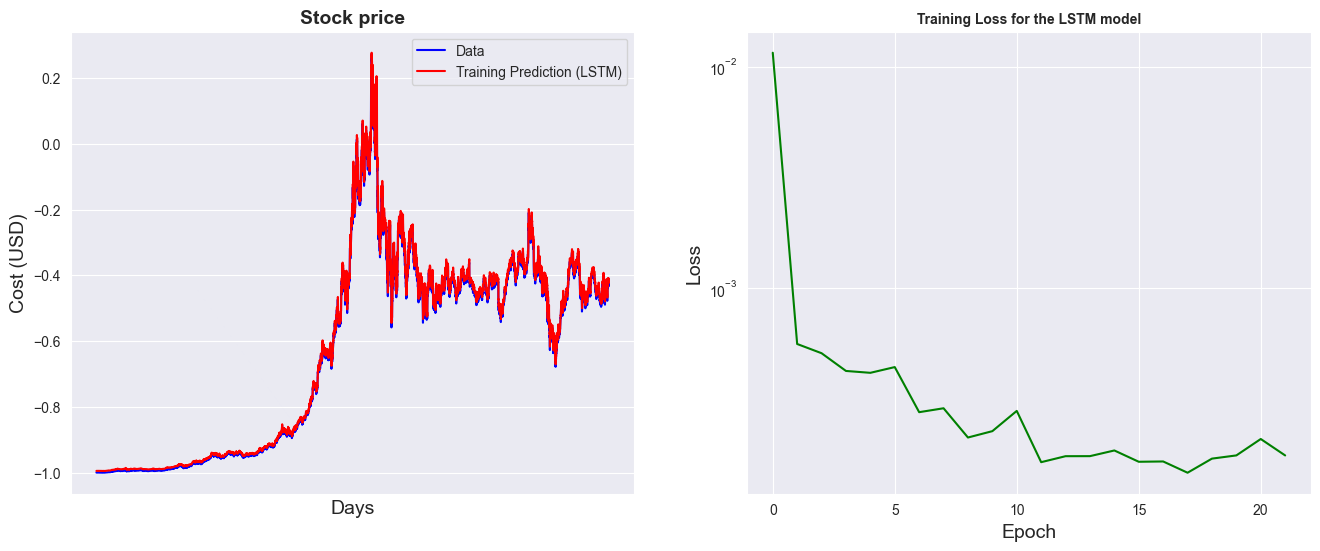

In [50]:
# Visualizing the training prediction
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
original = pd.DataFrame(y_train_lstm.cpu().numpy())
predict = pd.DataFrame(model(x_train).detach().cpu().numpy())
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticks([])
plt.savefig('images/lstm_prediction_training.png')


# Visualizing the training loss
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='green')
# Setting the y-axis to logarithmic scale for better visibility of loss values
ax.set_yscale("log")
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss for the LSTM model", size = 10, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig('images/lstm_training_loss.png')

# The training prediction for the LSTM model is really good.

## Evaluate the Model

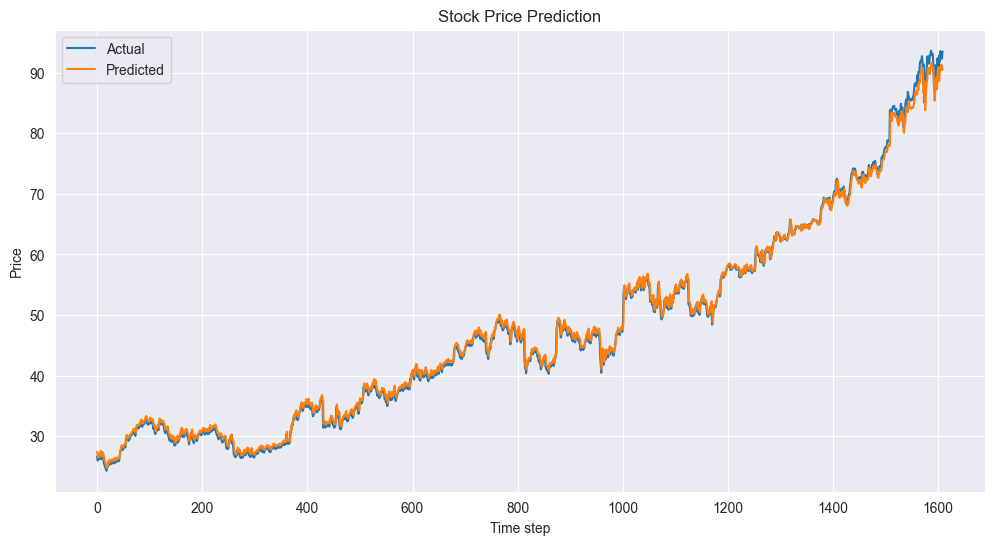

In [51]:
def evaluate_model(model, x_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test)
        true_values = y_test.cpu().numpy()

    # Inverse scale
    predictions_rescaled = scaler.inverse_transform(predictions.cpu().numpy())

    true_rescaled = scaler.inverse_transform(true_values)

    return predictions_rescaled, true_rescaled

predicted, actual = evaluate_model(model, x_test, y_test_lstm, scaler)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.title("Stock Price Prediction")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.legend()
plt.savefig('images/lstm_prediction.png')
plt.show()

# The model was performing better at the training dataset than the test dataset, which is a common issue in machine learning when overfitting occurs.
# LSTM model is composed of a cell, an input gate, an output gate, and a forget gate. This complicated model needs a lot of data to train properly
# If the model is trained on a small dataset (like the one I used here), it can lead to overfitting, where the model learns the training data too well and fails to generalize to new data.

# Results

In [52]:
model.eval()
with torch.no_grad():
    test_predictions = model(x_test)
    test_mse = loss_fn(test_predictions, y_test_lstm).item()


results = pd.DataFrame({
    "Metric": ["Train MSE", "Validation MSE", "Test MSE", "Training Time (s)"],
    "Value": [train_mse, val_mse, test_mse, train_time]
})

In [53]:
print(results)

              Metric       Value
0          Train MSE    0.000163
1     Validation MSE    0.000244
2           Test MSE    0.000369
3  Training Time (s)  174.489356


In [54]:
print("RMSE:", np.sqrt(mean_squared_error(actual, predicted))) # root mean squared error
print("R² Score:", r2_score(actual, predicted)) # coefficient of determination, how well the model explains the variance in the data

RMSE: 0.8982729553805815
R² Score: 0.9971883893013
